In [1]:
import pandas as pd
import numpy as np
import requests
import easymoney
from easymoney.money import EasyPeasy
import pycountry
import iso4217parse
from currency_converter import CurrencyConverter
from forex_python.converter import CurrencyRates
import datetime
import copy

%matplotlib inline
import seaborn
import matplotlib.pyplot as plt

/Users/muzikin/anaconda/envs/tensorforce/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [303]:
class BaseDataSet():
    
    def __init__(self, filename):
        self.filename = filename
        self.mcc_codes_table = pd.read_html(
            requests.get(
                'https://mcc-codes.ru/code', 
                headers={'User-agent': 'Mozilla/5.0'}
            ).text, 
            converters={'MCC': str}
        )[0]
        
        self.mcc_map = self.mcc_codes_table[[u'MCC', u'Группа']].set_index('MCC').to_dict()[u'Группа']
        
        self.rates = pd.read_csv('data/rub_exchange_rates.csv')
        
        self.data = None
        self.mcc_groups = None
        
        
    @staticmethod    
    def extract_month(s):
        day, month, year = s.split('/')
        month = int(month)
        month += (int(year) - 2016) * 12 
        return month 
    
    def _to_rur(self, obj):
        if obj['currency'] != 810:
            # Get currency:
            curr = iso4217parse.parse(int(obj['currency']))[0]

            if curr is not None:
                curr_alpha3 = curr[0]

            else:
                raise ValueError('Unknown currency code: {}'.format(obj['currency']))

            curr_amount = obj['amount']
            # Convert:
            try:
                obj['amount'] = curr_amount / self.rates.loc[curr_alpha3]['rate']
                #print('Converted {} {} to {} RUR'.format(curr_amount, curr_alpha3, obj['amount']))
            except KeyError as e:
                # Ex. rate not found, fake 1000 rub on tis transaction:
                print('WARNING: Rate missing for {} {}, substituted by 1000 RUR'.format(obj['amount'], curr_alpha3))
                obj['amount'] = 1000

        obj['currency'] = 643
        return obj
    
    @staticmethod
    def _day_to_int(obj):
        obj['rel_day'] = obj['rel_day'].days
        return obj

    def load_csv(self):
        self.data = pd.read_csv(self.filename)
        
        # TODO: TEMP!!!
        #self.data = self.data[0:1000]

        self.data['PERIOD'] = pd.to_datetime(
            self.data['PERIOD'], 
            format = '%m/%d/%Y'
        )
        self.data['TRDATETIME'] = pd.to_datetime(
            self.data['TRDATETIME'], 
            format = '%d%b%y:%X'
        )
        self.data['rel_day'] = self.data.apply(lambda zero: datetime.timedelta(), axis=1)
        self.data['channel_type'] = self.data['channel_type'].fillna('0').apply(lambda s : int(s[-1]))
        self.data['mcc_group'] = self.data['MCC'].astype(str).map(self.mcc_map)
        
        self.mcc_groups = self.data.mcc_group.unique()
        
        self.grouped_by_id = None

    def to_relative_days(self):
        self.grouped_by_id = self.data.groupby('cl_id')
        
        for cl_id, group in self.grouped_by_id:
            start_tstamp = copy.deepcopy(group['TRDATETIME'].min())
            idx = copy.deepcopy(group.index)
            self.data.loc[idx, 'rel_day'] = (self.data.loc[idx, 'TRDATETIME'] - start_tstamp)
            
        self.data = self.data.transform(self._day_to_int, axis=1)
        
    def to_rur(self):
        self.data = self.data.transform(self._to_rur, axis=1)
        
    def to_log(self):
        pass
    
    def aggregate_by_daily_sums(self):
        self.grouped_by_id = self.data.groupby('cl_id')
        new_idx = 0
        
        col_names = ['cl_id', 'rel_day', 'sum_POS']
        
        if 'target_flag' in self.data.columns:
            col_names += ['target_flag', 'target_sum']
            
        col_names += ['sum_{}'.format(group) for group in self.mcc_groups] 
        

        aggr_data = pd.DataFrame(
            index=None,
            columns=col_names
        ).fillna(0)

        for cl_id, cl_group in self.grouped_by_id:
            id_by_day = cl_group.groupby('rel_day')

            for day, ts_group in id_by_day:
                day_by_mcc = ts_group.groupby('MCC')
                day_sum_pos = 0                
                s = pd.Series(
                    name=new_idx,
                    index=col_names 
                ).fillna(0)
                s['cl_id'] = cl_id
                s['rel_day'] = day
                s['target_flag'] = ts_group.target_flag.all()
                s['target_sum'] = ts_group.target_sum.mean()

                for mcc_id, ts in day_by_mcc:
                    day_sum_pos += ts[ts.trx_category == 'POS']['amount'].sum()
                    s['sum_{}'.format(ts.mcc_group.values[0])] += ts['amount'].sum()
                
                s['sum_POS'] = day_sum_pos
                aggr_data = aggr_data.append(s)
                new_idx +=1
        
        return aggr_data

    
    def preprocess(self):
        
        if self.data is None:
            print('Reading data...')
            self.load_csv()
        
        print('Converting to RUB...')  
        self.to_rur()
        
        print('Inserting relative days...')  
        self.to_relative_days()
        
        print('Done.')
        

    
    

In [304]:
%%time

train = BaseDataSet('data/train.csv')
#test = load_dataset('data/test.csv')

train.preprocess()

Reading data...
Converting to RUB...
Inserting relative days...
Done.
CPU times: user 3min 15s, sys: 10.5 s, total: 3min 25s
Wall time: 3min 26s


In [305]:
%%time

aggr = train.aggregate_by_daily_sums()

CPU times: user 1h 16min 37s, sys: 34min 22s, total: 1h 51min
Wall time: 1h 51min 6s


In [308]:
train.data.shape

(490513, 12)

In [301]:
aggr

,cl_id,rel_day,sum_POS,target_flag,target_sum,sum_Розничные магазины,sum_Поставщик услуг,sum_Различные магазины,sum_Транспорт,sum_Магазины одежды,sum_Развлечения,sum_Бизнес услуги,sum_Государственные услуги,sum_Личные услуги,sum_Коммунальные и кабельные услуги,sum_Профессиональные услуги,sum_Отели и мотели,sum_Автомобили и транспортные средства,sum_Ремонтные услуги,sum_Аренда автомобилей
0,0.0,0.0,0.00,False,0.00,0.0,20000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,8.0,7054.00,False,0.00,7054.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,12.0,0.00,False,0.00,0.0,36562.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,53.0,767.00,False,0.00,0.0,0.0,767.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,265.50,False,0.00,0.0,0.0,265.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,1.0,300.00,False,0.00,300.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,3.0,399.00,False,0.00,0.0,0.0,399.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,5.0,300.00,False,0.00,0.0,0.0,300.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,6.0,300.00,False,0.00,300.0,50000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,7.0,898.00,False,0.00,598.0,0.0,300.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [302]:
train.data


,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,rel_day,mcc_group
0,2017-01-10,0,5200,0,643,2017-10-21 00:00:00,5023.000000,POS,0,0.00,8,Розничные магазины
1,2017-01-10,0,6011,0,643,2017-10-12 12:24:07,20000.000000,DEPOSIT,0,0.00,0,Поставщик услуг
2,2017-01-12,0,5921,0,643,2017-12-05 00:00:00,767.000000,POS,0,0.00,53,Различные магазины
3,2017-01-10,0,5411,0,643,2017-10-21 00:00:00,2031.000000,POS,0,0.00,8,Розничные магазины
4,2017-01-10,0,6012,0,643,2017-10-24 13:14:24,36562.000000,C2C_OUT,0,0.00,12,Поставщик услуг
5,2017-01-10,1,5814,0,643,2017-10-16 00:00:00,380.000000,POS,0,0.00,89,Различные магазины
6,2017-01-10,1,5814,0,643,2017-10-10 00:00:00,378.000000,POS,0,0.00,83,Различные магазины
7,2017-01-10,1,5814,0,643,2017-10-16 00:00:00,199.000000,POS,0,0.00,89,Различные магазины
8,2017-01-10,1,5814,0,643,2017-10-11 00:00:00,400.000000,POS,0,0.00,84,Различные магазины
9,2017-01-07,1,5411,0,643,2017-07-26 00:00:00,598.000000,POS,0,0.00,7,Розничные магазины


In [133]:
train.grouped_by_id.groups.keys()

dict_keys([0, 1, 5, 9, 10])

In [134]:
train.grouped_by_id[['rel_day']].first()

,rel_day
cl_id,
0,8 days 11:35:53
1,89 days 00:00:00
5,92 days 00:00:00
9,53 days 23:40:34
10,39 days 00:00:00


In [120]:
dir(train.grouped_by_id)

['MCC',
 'PERIOD',
 'TRDATETIME',
 '__bytes__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_accessors',
 '_add_numeric_operations',
 '_agg_doc',
 '_aggregate',
 '_aggregate_generic',
 '_aggregate_item_by_item',
 '_aggregate_multiple_funcs',
 '_apply_filter',
 '_apply_to_column_groupbys',
 '_apply_whitelist',
 '_assure_grouper',
 '_block_agg_axis',
 '_bool_agg',
 '_builtin_table',
 '_choose_path',
 '_concat_objects',
 '_constructor',
 '_cumcount_array',
 '_cython_agg_blocks',
 '_cython_agg_general',
 '_cython_table',
 '_cython_transform',
 '_decide_output_index',
 '_def_str',
 '_define_paths'

In [172]:
col_names = ['cl_id', 'rel_day', 'sum_POS', 'MCC'] + ['sum_{}'.format(group) for group in train.mcc_groups] 

s = pd.Series(
    name=7,
    index=col_names 
).fillna(0)


aggr = pd.DataFrame(
    index=None,
    columns=col_names
).fillna(0)

aggr = aggr.append(s)


s.name

aggr

,cl_id,rel_day,sum_POS,MCC,sum_Розничные магазины,sum_Поставщик услуг,sum_Различные магазины,sum_Транспорт,sum_Магазины одежды,sum_Развлечения,sum_Бизнес услуги,sum_Государственные услуги,sum_Личные услуги,sum_Коммунальные и кабельные услуги,sum_Профессиональные услуги,sum_Отели и мотели,sum_Автомобили и транспортные средства
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [191]:
train.mcc_map

{'0742': 'Контрактные услуги',
 '0763': 'Контрактные услуги',
 '0780': 'Контрактные услуги',
 '1520': 'Контрактные услуги',
 '1711': 'Контрактные услуги',
 '1731': 'Контрактные услуги',
 '1740': 'Контрактные услуги',
 '1750': 'Контрактные услуги',
 '1761': 'Контрактные услуги',
 '1771': 'Контрактные услуги',
 '1799': 'Контрактные услуги',
 '2741': 'Оптовые поставщики и производители',
 '2791': 'Оптовые поставщики и производители',
 '2842': 'Оптовые поставщики и производители',
 '3000': 'Авиалинии, авиакомпании',
 '3001': 'Авиалинии, авиакомпании',
 '3002': 'Авиалинии, авиакомпании',
 '3003': 'Авиалинии, авиакомпании',
 '3004': 'Авиалинии, авиакомпании',
 '3005': 'Авиалинии, авиакомпании',
 '3006': 'Авиалинии, авиакомпании',
 '3007': 'Авиалинии, авиакомпании',
 '3008': 'Авиалинии, авиакомпании',
 '3009': 'Авиалинии, авиакомпании',
 '3010': 'Авиалинии, авиакомпании',
 '3011': 'Авиалинии, авиакомпании',
 '3012': 'Авиалинии, авиакомпании',
 '3013': 'Авиалинии, авиакомпании',
 '3014': 'Авиа

In [203]:
new_idx = 0

col_names = ['cl_id', 'rel_day', 'sum_POS', 'MCC'] + ['sum_{}'.format(group) for group in train.mcc_groups] 


aggr_data = pd.DataFrame(
    index=None,
    columns=col_names
).fillna(0)

for cl_id, cl_group in train.grouped_by_id:
    id_by_day = cl_group.groupby('rel_day')
    
    for day, ts_group in id_by_day:
        day_by_mcc = ts_group.groupby('MCC')
        day_sum_pos = ts_group[ts_group.trx_category == 'POS']['amount'].sum()
        
        for mcc_id, ts in day_by_mcc:
            s = pd.Series(
                name=new_idx,
                index=col_names 
            ).fillna(0)
            s['cl_id'] = cl_id
            s['rel_day'] = int(day.days)
            s['sum_POS'] = ts[ts.trx_category == 'POS']['amount'].sum()
            s['MCC'] = mcc_id
            s['sum_{}'.format(train.mcc_map[str(mcc_id)])] = ts['amount'].sum()
            #print(s)

            aggr_data = aggr_data.append(s)
            new_idx +=1
            

In [204]:
aggr_data

,cl_id,rel_day,sum_POS,MCC,sum_Розничные магазины,sum_Поставщик услуг,sum_Различные магазины,sum_Транспорт,sum_Магазины одежды,sum_Развлечения,sum_Бизнес услуги,sum_Государственные услуги,sum_Личные услуги,sum_Коммунальные и кабельные услуги,sum_Профессиональные услуги,sum_Отели и мотели,sum_Автомобили и транспортные средства
0,0.0,0.0,0.00,6011.0,0.00,20000.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,8.0,5023.00,5200.0,5023.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,8.0,2031.00,5411.0,2031.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,12.0,0.00,6012.0,0.00,36562.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,53.0,767.00,5921.0,0.00,0.0,767.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,265.50,5814.0,0.00,0.0,265.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,300.00,5411.0,300.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,3.0,399.00,5814.0,0.00,0.0,399.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,5.0,300.00,5814.0,0.00,0.0,300.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,6.0,300.00,5411.0,300.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
train.data

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,rel_day,mcc_group
0,2017-01-10,0,5200,0,643,2017-10-21 00:00:00,5023.000000,POS,0,0.00,8,Розничные магазины
1,2017-01-10,0,6011,0,643,2017-10-12 12:24:07,20000.000000,DEPOSIT,0,0.00,0,Поставщик услуг
2,2017-01-12,0,5921,0,643,2017-12-05 00:00:00,767.000000,POS,0,0.00,53,Различные магазины
3,2017-01-10,0,5411,0,643,2017-10-21 00:00:00,2031.000000,POS,0,0.00,8,Розничные магазины
4,2017-01-10,0,6012,0,643,2017-10-24 13:14:24,36562.000000,C2C_OUT,0,0.00,12,Поставщик услуг
5,2017-01-10,1,5814,0,643,2017-10-16 00:00:00,380.000000,POS,0,0.00,89,Различные магазины
6,2017-01-10,1,5814,0,643,2017-10-10 00:00:00,378.000000,POS,0,0.00,83,Различные магазины
7,2017-01-10,1,5814,0,643,2017-10-16 00:00:00,199.000000,POS,0,0.00,89,Различные магазины
8,2017-01-10,1,5814,0,643,2017-10-11 00:00:00,400.000000,POS,0,0.00,84,Различные магазины
9,2017-01-07,1,5411,0,643,2017-07-26 00:00:00,598.000000,POS,0,0.00,7,Розничные магазины


In [ ]:
test_grouped_by_id = test.groupby('cl_id')
train_grouped_by_id = train.groupby('cl_id')

In [ ]:
test_num_tr_per_id = [len(value) for key, value in test_grouped_by_id.groups.items()]
train_num_tr_per_id = [len(value) for key, value in train_grouped_by_id.groups.items()]

print(len(test_num_tr_per_id))
print(len(train_num_tr_per_id))

test_obs_periods_by_id = {
    i: (g['TRDATETIME'].max() - g['TRDATETIME'].min()).days + 1 for i, g in test_grouped_by_id
}

train_obs_periods_by_id = {
    i: (g['TRDATETIME'].max() - g['TRDATETIME'].min()).days + 1 for i, g in train_grouped_by_id
}

In [ ]:
train_periods = np.asarray([v for k, v in train_obs_periods_by_id.items()])
test_periods = np.asarray([v for k, v in test_obs_periods_by_id.items()])

print('test: ', test_periods.min(), test_periods.max())
print('train: ', train_periods.min(), train_periods.max())

In [ ]:
# Relative transaction day for every client:
for cl_id, group in train_grouped_by_id:
    print('id: ', cl_id)
    start_tstamp = copy.deepcopy(group['TRDATETIME'].min())
    idx = copy.deepcopy(group.index)
    train.loc[idx, 'rel_day'] = (train.loc[idx, 'TRDATETIME'] - start_tstamp)

In [ ]:
def to_rel_day(obj):
    #obj['rel_day'] = datetime.timedelta(microseconds=obj['rel_day'] / 1000).days
    obj['rel_day'] = obj['rel_day'].days
    return obj

tr_2 = train.transform(to_rel_day, axis=1)

In [ ]:
train_grouped_by_id.get_group(10163)['TRDATETIME'].max()

In [ ]:
plt.figure(10)
_ = plt.hist(test_num_tr_per_id, bins=500)
_ = plt.hist(train_num_tr_per_id, bins=500)

In [ ]:
plt.figure(11)
_ = plt.hist(train_periods[train_periods < 90], bins=500)
_ = plt.hist(test_periods[test_periods < 90], bins=500)

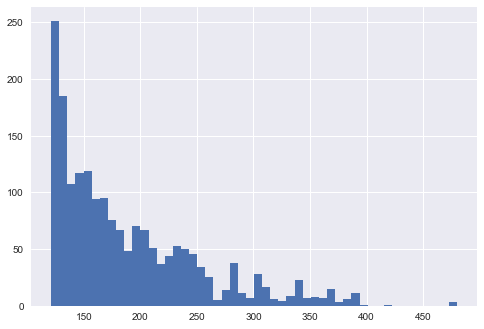

In [84]:
plt.figure(11)
data = train.data['rel_day'][train.data['rel_day'] > 120] 

#data = train.data['target_flag'][train.data['rel_day'] > 60] 
_ = plt.hist(data, bins=50)

In [79]:
v = [] 
for i in range(15):
    
    fract = train.data['target_flag'][train.data['rel_day'] < i*10 ]
    #print(fract)
    pos_fract = fract[fract == 1]
    #print(pos_fract)
    idx = pos_fract.index
    #print(idx)
    outs = train.data['cl_id'][idx].unique()
    #print(outs)
    v.append(outs.shape)
    
v

[(0,),
 (2767,),
 (2767,),
 (2767,),
 (2767,),
 (2767,),
 (2767,),
 (2767,),
 (2767,),
 (2767,),
 (2767,),
 (2767,),
 (2767,),
 (2767,),
 (2767,)]

In [68]:
c = train.data['target_flag'][train.data['rel_day'] < 10]
c = c[c > 0]
c

129       1
135       1
138       1
144       1
163       1
169       1
172       1
174       1
192       1
196       1
199       1
200       1
241       1
972       1
984       1
1007      1
1012      1
1033      1
1041      1
1044      1
1054      1
1056      1
1058      1
1062      1
1074      1
1383      1
1389      1
1393      1
1400      1
1420      1
         ..
490218    1
490237    1
490240    1
490256    1
490264    1
490268    1
490277    1
490283    1
490304    1
490452    1
490454    1
490455    1
490457    1
490458    1
490460    1
490461    1
490463    1
490468    1
490475    1
490477    1
490478    1
490479    1
490481    1
490482    1
490483    1
490490    1
490491    1
490492    1
490498    1
490504    1
Name: target_flag, Length: 41729, dtype: int64

In [ ]:
test[test['cl_id'] == 223]

In [ ]:
codes = list(
    (set(train['currency'].unique()) | set(test['currency'].unique())) - {810}
)
alpha_3_list = [iso4217parse.parse(int(code))[0].alpha3 for code in codes]

alpha_3_request = ''
for code in alpha_3_list:
    alpha_3_request += '{}, '.format(code)

api_key = '2639ccac02d7c15359d45f9a2bc9d8ea'
params = {'access_key': api_key, 'currencies': alpha_3_request, 'format': 1}
r = requests.get('http://apilayer.net/api/live', params = params)
response = r.json()['quotes']
base_curr = response['USDRUB']
rates_base_rub = {key[3:]: value / base_curr for key, value in response.items()}



In [ ]:
response = r.json()['quotes']
base_curr = response['USDRUB']
rates_base_rub = {key[3:]: value / base_curr for key, value in response.items()}

In [ ]:
pd_rates = pd.DataFrame.from_dict(rates_base_rub, orient='index', columns=['rate'])
pd_rates

pd_rates.to_csv('rub_exchange_rates.csv', index=True, index_label=False)

rates = pd.read_csv('rub_exchange_rates.csv')
rates

In [ ]:
rates.loc['MAD']['rate']

In [ ]:
train

In [ ]:
dataset = test

def to_rur(obj):
    
    if obj['currency'] != 810:
        # Get currency:
        curr = iso4217parse.parse(int(obj['currency']))[0]
        
        if curr is not None:
            curr_alpha3 = curr[0]
            
        else:
            raise ValueError('Unknown currency code: {}'.format(obj['currency']))
            
        curr_amount = obj['amount']
        # Convert:
        try:
            obj['amount'] = curr_amount / rates.loc[curr_alpha3]['rate']
            #print('Converted {} {} to {} RUR'.format(curr_amount, curr_alpha3, obj['amount']))
        except KeyError as e:
            # Ex. rate not found, fake 1000 rub on tis transaction:
            print('WARNING: Rate missing for {} {}, substituted by 1000 RUR'.format(obj['amount'], curr_alpha3))
            obj['amount'] = 1000
    
    obj['currency'] = 643

    return obj
   
    
rub_dataset = dataset.transform(to_rur, axis=1)

In [ ]:
rub_dataset.to_csv('test_643.csv', index=True, index_label=False) 
new_train = pd.read_csv('test_643.csv')
new_train

In [ ]:
def log_transform(obj):
    obj['amount'] = np.log(obj['amount'] + 1)
    #print()
    if 'target_sum' in obj.index:
        obj['target_sum'] = np.log(obj['target_sum'] + 1)
    return obj

#train = pd.read_csv('train_643.csv')
#test = pd.read_csv('test_643.csv')

In [ ]:
log_train = train.transform(log_transform, axis=1)
log_test = test.transform(log_transform, axis=1)

In [ ]:
log_train['target_sum'].max()

In [ ]:
_ = plt.hist(log_train['amount'], bins=100)

In [ ]:
_ = plt.hist(log_test['amount'], bins=100)

In [ ]:
_ = plt.hist(log_train['target_sum'], bins=100)

In [ ]:
log_train.to_csv('train_643_log.csv', index=True, index_label=False) 
log_test.to_csv('test_643_log.csv', index=True, index_label=False) 

train = pd.read_csv('train_643.csv')
test = pd.read_csv('test_643.csv')

In [ ]:
log_test

In [ ]:
mcc_groups = train.mcc_group.unique()

def build_features(data):
    aggregated = data.groupby('cl_id')[[ 
        'channel_type',
    ]].first()
    ids = aggregated.index
    aggregated['cl_id'] = ids
    aggregated['sum_POS'] = data[data.trx_category == 'POS'].groupby('cl_id')['amount'].sum()
    if 'target_sum' in data.columns:
        aggregated['target_sum'] = data.groupby('cl_id')['target_sum'].sum()
    for mcc_group in mcc_groups:
        aggregated['sum_%s' % mcc_group] = data[
            (data.mcc_group == mcc_group)
        ].groupby('cl_id')['amount'].sum()
    
    return aggregated.fillna(0)

train_agg = build_features(train)
test_agg = build_features(test)

log_train_agg = build_features(log_train)
log_test_agg = build_features(log_test)


features = train_agg.columns
print(features)


In [ ]:
train_agg.describe()

In [ ]:
log_stat = log_train_agg.describe()

In [ ]:
log_stat['sum_POS']['std']

In [ ]:
log_train_agg['sum_POS_zscore'] = log_train_agg['sum_POS']/log_train_agg['sum_POS'].std(ddof=0)

In [ ]:
plt.figure(0)
_ = plt.hist(np.log(train_agg['sum_POS'].values), bins=100)
_ = plt.hist(np.log(log_train_agg['sum_POS'].values), bins=100)
_ = plt.hist(np.log(log_train_agg['sum_POS_zscore'].values), bins=100)

In [ ]:
plt.figure(1)
_ = plt.hist(np.log(train_agg['target_sum'].values + 1), bins=50)
_ = plt.hist(np.log(log_train_agg['target_sum'].values + 1), bins=50)
#_ = plt.hist(log_train_agg['target_sum'].values + 1, bins=50)

In [ ]:
plt.figure(2)
_ = plt.hist(np.log(train_agg['sum_POS'].values), bins=50)
_ = plt.hist(np.log(train_agg['target_sum'].values + 1), bins=50)

In [ ]:
plt.figure(3)
_ = plt.hist(np.log(log_train_agg['sum_POS'].values), bins=1000)
_ = plt.hist(np.log(train_agg['target_sum'].values[train_agg['target_sum'].values != 0] )/2.55, bins=1000)

In [ ]:
plt.figure(4)
r = np.log(log_train_agg['sum_POS'].values / (train_agg['target_sum'].values + 1))
_ = plt.hist(r, bins=500)

In [ ]:
_ = plt.plot(train_agg['target_sum'].values)

In [ ]:
dt = datetime.datetime.strptime(log_train['PERIOD'][0], '%m/%d/%Y')

In [ ]:
dt.date()